In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix, AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.likelihood import get_dh, get_hh
import tools.likelihood as likelihood

from tools.time_freq_likelihood import TimeFreqLikelihood

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [ ]:
Tobs = YRSID_SI/2
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

f_ref = 0.0
phi_ref = 0.0
m1 = 7e5
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 10e3 * PC_SI * 1e6  # 3e3 in Mpc
inc = np.pi/3
beta = np.pi/4.
lam = np.pi/1.
psi = np.pi/6.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

In [3]:
nperseg = 5000
time_before_merger=60*60*24
cutoff_time = t_ref - time_before_merger
max_time = Tobs

[3316.99364388]
3317.106535632151


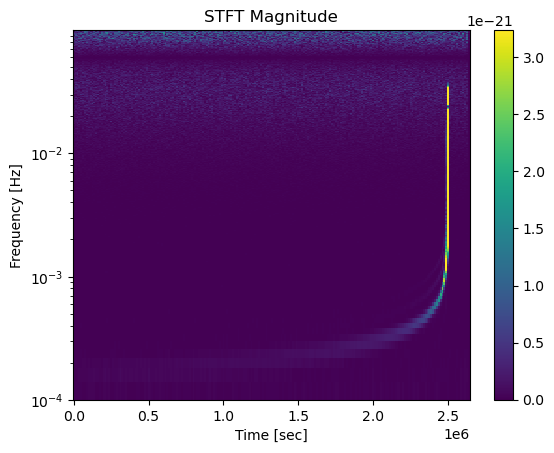

In [4]:
sim.plot_time_frequency(nperseg=nperseg)
print(sim.SNR_optimal())
print(likelihood.template_snr(data_f, sim.signal_f, AE1SensitivityMatrix(f_array), df=sim.df))

In [5]:
# Check is the likelihood is zero by computing the likelihood of a template with the true parameters with the noise-free signal.
analysis_no_noise = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen)
analysis_no_noise.get_stft_of_data()
analysis_no_noise.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=f_array,
        modes=modes
    )
)

np.float64(0.0)

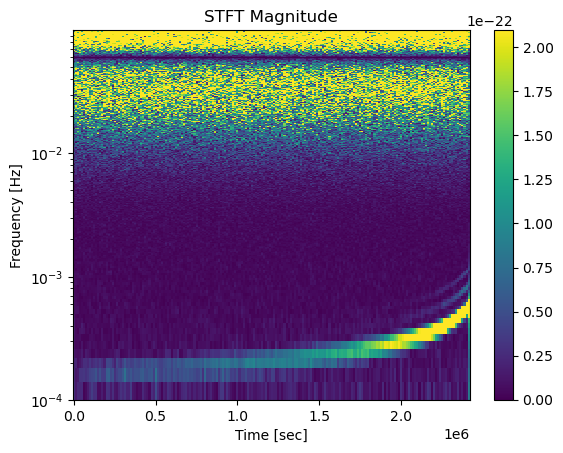

In [6]:
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
analysis.pre_merger(time_before_merger=time_before_merger, t_ref=t_ref, t_array=t_array, )
analysis.get_stft_of_data()
analysis.plot_spectrogram()

In [7]:
print("Best likelihood (true parameters)= ", analysis.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))
print("Likelihood of a random template = ", analysis.calculate_time_frequency_likelihood(
    m1 *20* (1 + 1e-7 * np.random.randn(1))[0],
    m2 * (1 + 1e-7 * np.random.randn(1))[0], 
    a1,
    a2,
    dist * 10, 
    phi_ref * (1 + 1e-7 * np.random.randn(1))[0],
    f_ref, 
    inc,
    lam*2,
    beta,
    psi,
    t_ref * (1 + 1e-7 * np.random.randn(1))[0],
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))#/analysis.dt

Best likelihood (true parameters)=  -38.60062399816449
Likelihood of a random template =  -62.28138072699121


In [8]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [9]:
# x = [lambda, beta]. They are the only variable parameters.
def likelihood(x, fixed_parameters, freqs, TimeFreqLikelihood_object):
    all_parameters = np.zeros(12)
    all_parameters[8] = x[0]
    all_parameters[9] = np.arcsin(x[1])
    all_parameters[-1] = x[2]
    all_parameters[np.array([0, 1, 2, 3, 4, 5, 6, 7, 10])] = fixed_parameters

    ll = TimeFreqLikelihood_object.calculate_time_frequency_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=freqs,
        modes=modes
        )
    )
    return ll

In [10]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(0.0, 2 * np.pi),
    1: uniform_dist(-1, 1),
    2: uniform_dist(cutoff_time, max_time), # 1 week after the cutoff time
})}

fixed_parameters = np.array([
    m1,
    m2,
    a1,
    a2,
    dist,
    phi_ref, 
    f_ref, 
    inc,
    psi,
])

periodic = {"mbh": {0: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 3}

In [11]:
x = priors["mbh"].rvs(size=(nwalkers))[0]
x, likelihood(x, fixed_parameters, f_array, analysis)

(array([2.03001380e-01, 5.95418114e-01, 2.47110825e+06]),
 np.float64(-72.25580359716541))

In [12]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(fixed_parameters, f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [ ]:
injection_params_sub = np.array([lam, beta, t_ref])
#start_params = injection_params_sub[None, None, None, :] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))

start_params = priors["mbh"].rvs(size=(ntemps, nwalkers, 1))

start_params[:, :, :, 0] = injection_params_sub[None, None, None, 0] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1))
start_params[:, :, :, 1] = injection_params_sub[None, None, None, 0] * (1 + 0.1 * np.random.randn(ntemps, nwalkers, 1))

#start_params[:, :, :, 2] = injection_params_sub[None, None, None, 2] * (1 + 0.01 * np.random.randn(ntemps, nwalkers, 1))

#start_params[..., 2] = np.random.uniform(cutoff_time, max_time, size=(ntemps, nwalkers, 1))

In [31]:
priors["mbh"].rvs(size=(ntemps, nwalkers, 1)).shape, start_params.shape

((10, 32, 1, 3), (10, 32, 1, 3))

In [14]:
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)

array([[-14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039],
       [-14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14.82278039, -14.82278039,
        -14.82278039, -14.82278039, -14

In [15]:
sampler.run_mcmc(start_state, 10, progress=True)

100%|██████████| 10/10 [11:56<00:00, 71.69s/it]


Parameter lam in chain An Example Contour is not constrained
Parameter beta in chain An Example Contour is not constrained
Parameter t_ref in chain An Example Contour is not constrained


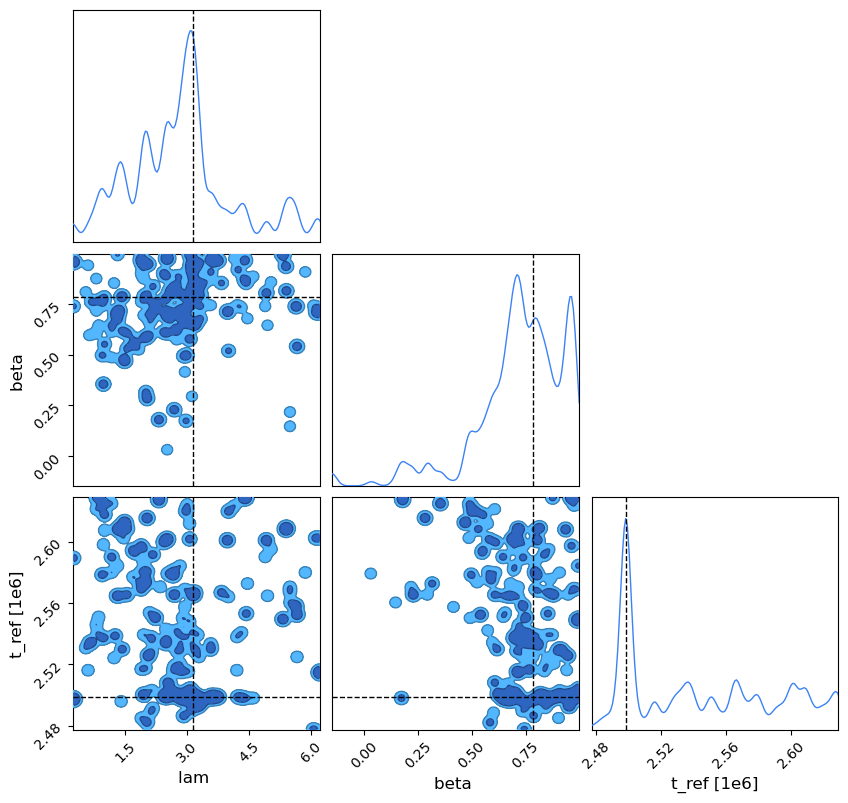

In [20]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 3)
df = pd.DataFrame(samples, columns=["lam", "beta", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"lam": injection_params_sub[0], "beta": injection_params_sub[1], "t_ref": injection_params_sub[2]}))
fig = c.plotter.plot()

In [33]:
lam, beta, t_ref/1e6

(3.141592653589793, 0.7853981633974483, 2.4983535229473604)

To get uniformly distributed points on the sphere, do not sample θ linearly. Instead:

Sample sin(θ) ∈ [-1, 1] uniformly

Sample φ ∈ [0, 2π] uniformly
